## Imports

In [1]:
!pip install split-folders  # install split folder to split all folders randomly for train, test, val

In [2]:
# import required libraries
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

### Defining the path for test and train data

In [3]:
from google.colab import drive # Mounting drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import splitfolders

input_folder = '/content/drive/MyDrive/Plant seedling Classification' # Folder where images of all classes stored
output_folder = '/content/dataset'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .0, .2)) # splitted data train, val,test

Copying files: 5609 files [02:26, 38.25 files/s] 


Folder named dataset is created inside train,test, valid folders are present.

In [5]:
import glob

train_length = 0
test_length = 0

for name in glob.glob('/content/dataset/train/*'):
  train_length += len(glob.glob(name+'/*.png'))

for name in glob.glob('/content/dataset/test/*'):
  test_length += len(glob.glob(name+'/*.png'))

print(train_length,test_length)

4481 1128


### Load using keras.preprocessing

### Creating the dataset

In [6]:
batch_size = 32
img_height = 120
img_width = 120

In [7]:
data_dir_train = '/content/dataset/train' # path for train dataset
data_dir_test = '/content/dataset/test'

In [8]:
# creating train dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split=0.2, subset="training", seed=123,
                                                               image_size=(img_height, img_width), batch_size=batch_size)

Found 4481 files belonging to 12 classes.
Using 3585 files for training.


In [9]:
# creating validation dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split=0.2, subset="validation", seed=123,
                                                             image_size=(img_height, img_width), batch_size=batch_size)

Found 4481 files belonging to 12 classes.
Using 896 files for validation.


In [10]:
# Listing out all the classes of plant seedlings and store them in a list (Folder names of each category are classes).

labels = sorted(os.listdir(data_dir_train))
print(labels)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherd’s Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [11]:
# creating a list which counts the number of images in each class of plant seedling
count_plot = []
for i in labels:
    count_plot.append(len(os.listdir(os.path.join(data_dir_train,i))))

In [12]:
count_plot  # Number of images of each class

[247, 361, 273, 570, 202, 432, 628, 205, 514, 219, 460, 370]

### Visualizing the data

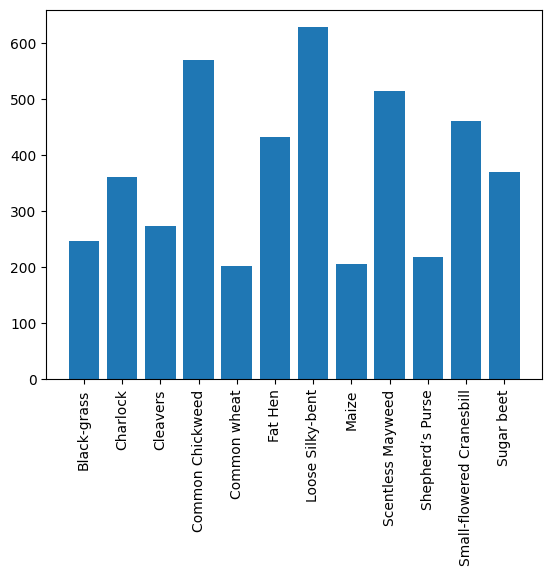

In [13]:
# creating plot for distribution of images in each class
count_plot = np.array(count_plot)
plt.bar(labels, count_plot)
plt.xticks(rotation = 90)
plt.show()

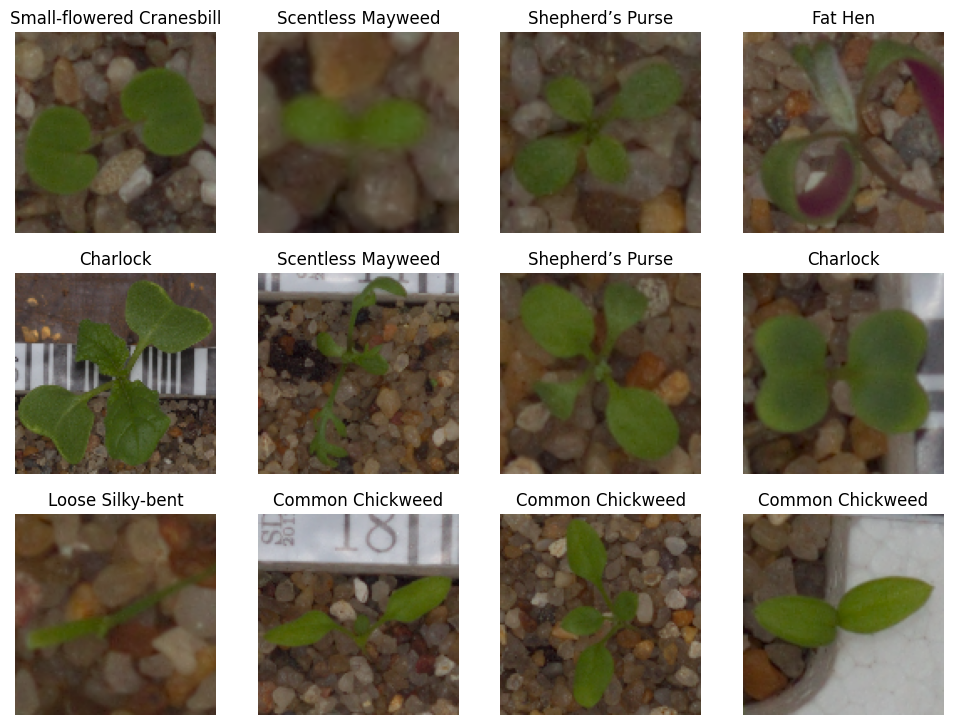

In [14]:
# visualizing few images from the train data
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
for image, label in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(labels[label[i]])
    plt.axis("off")

## Creating the model

### Model 1
Creating a CNN model, which can accurately detect 12 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [18]:
# specifying image dimensions with RGB channel
input_shape = (120,120,3)
# storing number of classes of plant seedlings in a variable
num_classes = 12

# creating layers for the first model using conv2D
model1 = Sequential()
model1.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset=0.0, input_shape=input_shape))
model1.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding='same'))
model1.add(Activation('relu'))
# using batch normalization
model1.add(BatchNormalization())
model1.add(Conv2D(32, kernel_size=(3, 3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(64, (3, 3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(Conv2D(128, (3, 3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(256))
model1.add(Activation('relu'))
model1.add(Dense(num_classes))
model1.add(Activation('softmax'))

In [21]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 120, 120, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 120, 120, 32)      896       
                                                                 
 activation (Activation)     (None, 120, 120, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 120, 120, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 118, 118, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 118, 118, 32)      0         
                                                        

In [22]:
### Compiling the model
### choosing an appropirate optimiser and loss function
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
### Training the model
epochs = 100
batch_size = 32
history = model1.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size)

Epoch 1/100
113/113 [==============================] - 54s 305ms/step - loss: 2.4185 - accuracy: 0.4971 - val_loss: 15.2265 - val_accuracy: 0.1406
Epoch 2/100
113/113 [==============================] - 30s 250ms/step - loss: 0.8032 - accuracy: 0.7529 - val_loss: 26.0054 - val_accuracy: 0.1406
Epoch 3/100
113/113 [==============================] - 29s 243ms/step - loss: 0.6073 - accuracy: 0.8064 - val_loss: 12.4528 - val_accuracy: 0.1462
Epoch 4/100
113/113 [==============================] - 28s 241ms/step - loss: 0.3540 - accuracy: 0.8725 - val_loss: 9.5190 - val_accuracy: 0.1574
Epoch 5/100
113/113 [==============================] - 29s 241ms/step - loss: 0.2712 - accuracy: 0.9026 - val_loss: 3.2183 - val_accuracy: 0.4219
Epoch 6/100
113/113 [==============================] - 28s 239ms/step - loss: 0.6282 - accuracy: 0.8120 - val_loss: 1.5419 - val_accuracy: 0.7299
Epoch 7/100
113/113 [==============================] - 28s 241ms/step - loss: 0.3047 - accuracy: 0.8968 - val_loss: 1.240

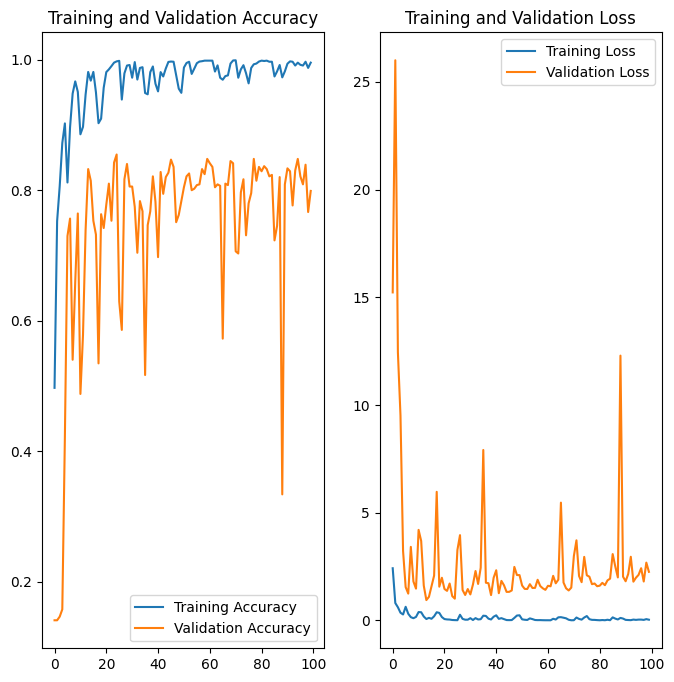

In [24]:
### visualizing the model results.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations and results from Model 1
1. The accuracy of the model for the training data set is at 99.58%. But the Validation accuracy is not in par with the training accuracy.
It is only at 79.91%. Also model achieved 95% accuracy at 10th epoch but not even able to acieve 85% accuracy till last epoch.

2. Comparing training and valid accuracy plots, validation plot has many flactuations.

3. The validation loss as observed is very high.

  These are indications of overfitting model.


### Model 2
####Adding Dropouts.
1. Adding dropouts after every hidden layer to avoid overfitting.
2. Adding one more dense layer.
3. Using early stopping.



In [25]:
input_shape = (120,120,3)
num_classes = 12

model2 = Sequential()
# adding layers for normalizing the images between 0 and 1
model2.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset=0.0, input_shape=input_shape))
model2.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(32, kernel_size=(3, 3)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.20))

model2.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.20))

model2.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.20))

model2.add(Flatten())
model2.add(Dense(2048))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.20))
model2.add(Dense(256))
model2.add(Activation('relu'))
model2.add(Dense(num_classes))
model2.add(Activation('softmax'))

In [27]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 120, 120, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 120, 120, 32)      896       
                                                                 
 activation_8 (Activation)   (None, 120, 120, 32)      0         
                                                                 
 batch_normalization_6 (Batc  (None, 120, 120, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 118, 118, 32)      9248      
                                                                 
 activation_9 (Activation)   (None, 118, 118, 32)      0         
                                                      

In [28]:
### compiling the model
### choosing an appropirate optimiser and loss function
opt = Adam(0.001) # specifying the optimizer used for the model
model2.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
# specifying the format in which model needs to be saved
model_name = 'Seed2' + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)
 # giving the file path
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{val_loss:.5f}-.h5'
# Creating the call back for saving only the best models
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# creating the callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

callbacks_list = [checkpoint, early_stopping]

In [30]:
### training the model and using callback parameter to save the best model
epochs = 100
batch_size = 32
history = model2.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/100
112/113 [============================>.] - ETA: 0s - loss: 1.6010 - accuracy: 0.5617
Epoch 1: val_loss improved from inf to 20.30350, saving model to Seed2/model-00001-1.60125-20.30350-.h5
113/113 [==============================] - 39s 269ms/step - loss: 1.6013 - accuracy: 0.5615 - val_loss: 20.3035 - val_accuracy: 0.0458
Epoch 2/100
112/113 [============================>.] - ETA: 0s - loss: 0.9294 - accuracy: 0.7310
Epoch 2: val_loss improved from 20.30350 to 13.80148, saving model to Seed2/model-00002-0.92984-13.80148-.h5
113/113 [==============================] - 37s 313ms/step - loss: 0.9298 - accuracy: 0.7308 - val_loss: 13.8015 - val_accuracy: 0.1440
Epoch 3/100
112/113 [============================>.] - ETA: 0s - loss: 0.8060 - accuracy: 0.7706
Epoch 3: val_loss did not improve from 13.80148
113/113 [==============================] - 30s 257ms/step - loss: 0.8065 - accuracy: 0.7704 - val_loss: 15.4261 - val_accuracy: 0.0480
Epoch 4/100
112/113 [======================

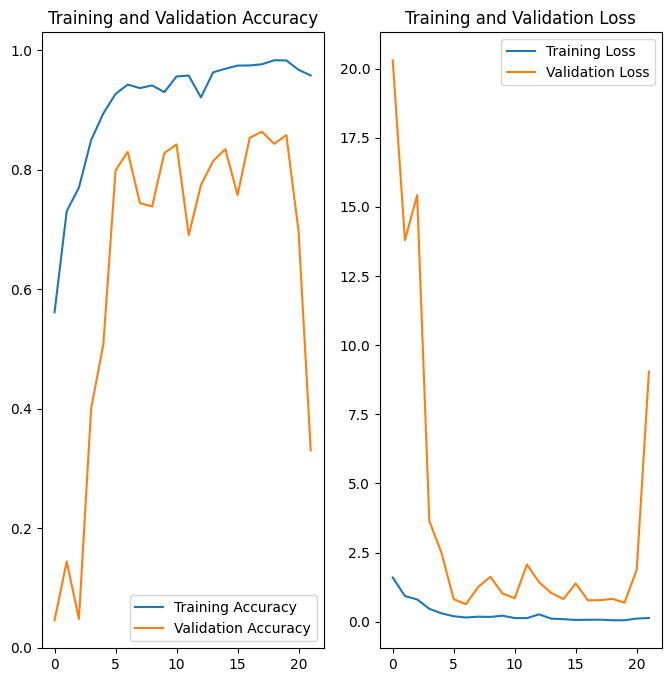

In [31]:
### visualizing the model results.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(22)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observations and results from Model 2
1. The model is performing better than the previous model since there is comparatively less overfitting. Model training stopped after 22 epochs.
2. Training accuracy of 96% and validation accuracy of 85% at 20th epoch.
3. Validation loss is improved from 2.25 to 0.69.
4. Model is still overfitted and sharp fluctuations are there in val_accuracy graph.

## Model 3
#### Creating a model using data augmetation
1. layers.experimental.preprocessing.RandomFlip() - A preprocessing layer which randomly flips images during training.
2. layers.experimental.preprocessing.RandomRotation() - A preprocessing layer which randomly rotates images during training.
3. Remove batchnormalization layer.

In [33]:
input_shape = (120,120,3)
num_classes = 12

model_aug = Sequential()
# scaling the images
model_aug.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset=0.0))
#layers.experimental.preprocessing.RandomFlip() - A preprocessing layer which randomly flips images during training.
#layers.experimental.preprocessing.RandomRotation() - A preprocessing layer which randomly rotates images during training.
model_aug.add(tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"))
model_aug.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.2))
model_aug.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding='same'))
model_aug.add(Activation('relu'))
model_aug.add(Conv2D(32, kernel_size=(3, 3)))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))
# adding dropout layer after each Maxpooling layer
model_aug.add(Dropout(0.20))

model_aug.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model_aug.add(Activation('relu'))
model_aug.add(Conv2D(64, (3, 3)))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_aug.add(Dropout(0.20))

model_aug.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model_aug.add(Activation('relu'))
model_aug.add(Conv2D(128, (3, 3)))
model_aug.add(Activation('relu'))
model_aug.add(MaxPooling2D(pool_size=(2, 2)))
model_aug.add(Dropout(0.20))

model_aug.add(Flatten())
model_aug.add(Dense(512))
model_aug.add(Activation('relu'))
model_aug.add(Dropout(0.20))
model_aug.add(Dense(num_classes))
model_aug.add(Activation('softmax'))

In [34]:
### compiling the augmented model
### choosing an appropirate optimiser and loss function

opt = Adam(0.001)
model_aug.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
# spefying the format in which model needs to be saved
model_name = 'Seed3' + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)
 # giving the file path
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{val_loss:.5f}-.h5'
# Creating the call back for saving only the best models
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# creating the callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)

callbacks_list = [checkpoint, early_stopping]

In [ ]:
### training the model
epochs = 100
batch_size = 32
history = model_aug.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, shuffle=True)

Epoch 1/100
112/113 [============================>.] - ETA: 0s - loss: 2.2594 - accuracy: 0.2070
Epoch 1: val_loss improved from inf to 1.83801, saving model to Seed3/model-00001-2.25922-1.83801-.h5
113/113 [==============================] - 32s 239ms/step - loss: 2.2592 - accuracy: 0.2070 - val_loss: 1.8380 - val_accuracy: 0.3728
Epoch 2/100
112/113 [============================>.] - ETA: 0s - loss: 1.6183 - accuracy: 0.4182
Epoch 2: val_loss did not improve from 1.83801
113/113 [==============================] - 28s 238ms/step - loss: 1.6182 - accuracy: 0.4181 - val_loss: 2.0022 - val_accuracy: 0.3292
Epoch 3/100
112/113 [============================>.] - ETA: 0s - loss: 1.3346 - accuracy: 0.5391
Epoch 3: val_loss improved from 1.83801 to 1.09079, saving model to Seed3/model-00003-1.33640-1.09079-.h5
113/113 [==============================] - 28s 240ms/step - loss: 1.3364 - accuracy: 0.5389 - val_loss: 1.0908 - val_accuracy: 0.6339
Epoch 4/100
112/113 [============================>.]

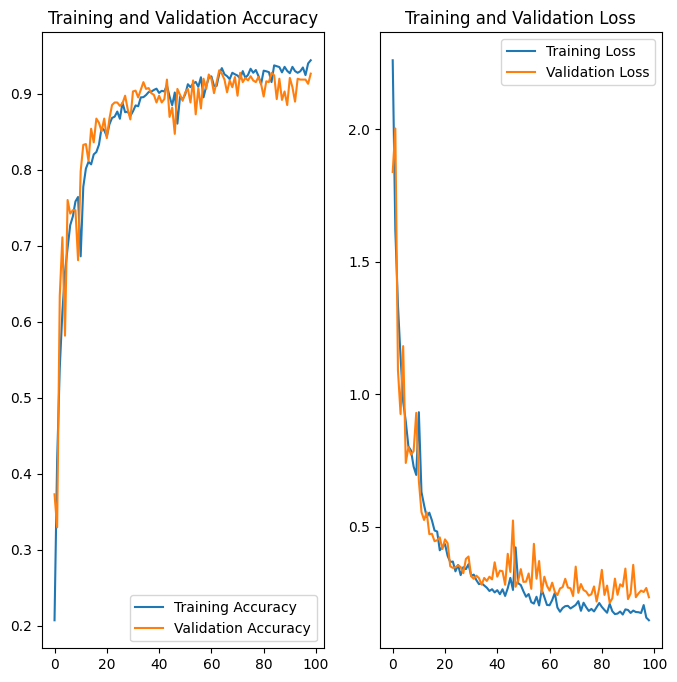

In [38]:
### visualizing the model results.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(99)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Results from Model 3
1. Including Data Augmentation has improved the model accuracy to 92% and also handled overfitting to great extent.
2. Data Augmentation has improved the model performance.
3. Validation loss have improved from 0.69 to 0.213
4. Removing batch normalization helped to reduce overfitting.

## Model 4

Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [26]:
### defining the path for training and test images
train_path = "/content/dataset/train/"
test_path = "/content/dataset/test/"

In [27]:
### distibution of classes for each category of data
### It can be seen that data has imbalances in the class distribution
for i in labels:
    directory =train_path + i + '/'
    class_directory = pathlib.Path(directory)
    length=len(list(class_directory.glob('*.png')))
    print(f'{i} has {length} samples.')

Black-grass has 247 samples.
Charlock has 361 samples.
Cleavers has 273 samples.
Common Chickweed has 570 samples.
Common wheat has 202 samples.
Fat Hen has 432 samples.
Loose Silky-bent has 628 samples.
Maize has 205 samples.
Scentless Mayweed has 514 samples.
Shepherd’s Purse has 219 samples.
Small-flowered Cranesbill has 460 samples.
Sugar beet has 370 samples.


In [28]:
# You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes
# so that none of the classes have very few samples.
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

1. Instantiate a Pipeline object pointing to a directory containing your initial image data set.
2. Define a number of operations to perform on this data set using your Pipeline object.
3. Execute these operations by calling the Pipeline’s sample() method.

In [29]:
path_to_training_dataset=train_path

import Augmentor
for i in labels:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 247 image(s) found.
Output directory set to /content/dataset/train/Black-grass/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=182x182 at 0x7B90AA23BAF0>: 100%|██████████| 500/500 [02:30<00:00,  3.31 Samples/s]


Initialised with 361 image(s) found.
Output directory set to /content/dataset/train/Charlock/output.

Processing <PIL.Image.Image image mode=RGB size=335x335 at 0x7B90AA207BB0>: 100%|██████████| 500/500 [01:00<00:00,  8.28 Samples/s]


Initialised with 273 image(s) found.
Output directory set to /content/dataset/train/Cleavers/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=122x122 at 0x7B90AA3668C0>: 100%|██████████| 500/500 [00:28<00:00, 17.50 Samples/s]


Initialised with 570 image(s) found.
Output directory set to /content/dataset/train/Common Chickweed/output.

Processing <PIL.Image.Image image mode=RGB size=166x166 at 0x7B90AA0BF940>: 100%|██████████| 500/500 [00:22<00:00, 22.19 Samples/s]


Initialised with 202 image(s) found.
Output directory set to /content/dataset/train/Common wheat/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=120x120 at 0x7B90AA0C7AC0>: 100%|██████████| 500/500 [01:07<00:00,  7.42 Samples/s]


Initialised with 432 image(s) found.
Output directory set to /content/dataset/train/Fat Hen/output.

Processing <PIL.Image.Image image mode=RGB size=85x85 at 0x7B90AA0BDF00>: 100%|██████████| 500/500 [00:37<00:00, 13.38 Samples/s]


Initialised with 628 image(s) found.
Output directory set to /content/dataset/train/Loose Silky-bent/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=443x443 at 0x7B90AA0FF0D0>: 100%|██████████| 500/500 [00:59<00:00,  8.43 Samples/s]


Initialised with 205 image(s) found.
Output directory set to /content/dataset/train/Maize/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=593x593 at 0x7B90AA0F4130>: 100%|██████████| 500/500 [01:21<00:00,  6.11 Samples/s]


Initialised with 514 image(s) found.
Output directory set to /content/dataset/train/Scentless Mayweed/output.

Processing <PIL.Image.Image image mode=RGB size=703x703 at 0x7B90AA0FF280>: 100%|██████████| 500/500 [00:27<00:00, 18.24 Samples/s]


Initialised with 219 image(s) found.
Output directory set to /content/dataset/train/Shepherd’s Purse/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=76x76 at 0x7B90AA366950>: 100%|██████████| 500/500 [00:35<00:00, 14.26 Samples/s]


Initialised with 460 image(s) found.
Output directory set to /content/dataset/train/Small-flowered Cranesbill/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGB size=249x249 at 0x7B90AA117B80>: 100%|██████████| 500/500 [00:39<00:00, 12.69 Samples/s]


Initialised with 370 image(s) found.
Output directory set to /content/dataset/train/Sugar beet/output.

Processing <PIL.Image.Image image mode=RGB size=183x183 at 0x7B90AA0FE530>: 100%|██████████| 500/500 [01:38<00:00,  5.06 Samples/s]


In [30]:
### Distribution of classes after augmentation
for i in labels:
    directory =train_path+i+'/'
    directory_out =train_path+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob('*.png')))
    length_out=len(list(class_directory_out.glob('*.png')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

Black-grass has 747 samples.
Charlock has 861 samples.
Cleavers has 773 samples.
Common Chickweed has 1070 samples.
Common wheat has 702 samples.
Fat Hen has 932 samples.
Loose Silky-bent has 1128 samples.
Maize has 705 samples.
Scentless Mayweed has 1014 samples.
Shepherd’s Purse has 719 samples.
Small-flowered Cranesbill has 960 samples.
Sugar beet has 870 samples.


In [31]:
batch_size = 32
img_height = 120
img_width = 120

In [32]:
data_dir_train=train_path
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10481 files belonging to 12 classes.
Using 8385 files for training.


In [33]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10481 files belonging to 12 classes.
Using 2096 files for validation.


In [38]:
input_shape = (120,120,3)
num_classes = 12

model4 = Sequential()
model4.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset=0.0))
model4.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding='same'))
model4.add(Activation('relu'))
model4.add(Conv2D(32, kernel_size=(3, 3)))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.10))

model4.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model4.add(Activation('relu'))
model4.add(Conv2D(64, (3, 3)))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.10))

model4.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model4.add(Activation('relu'))
model4.add(Conv2D(128, (3, 3)))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.10))

model4.add(Flatten())
model4.add(Dense(256))
model4.add(Activation('relu'))
model4.add(Dropout(0.25))
model4.add(Dense(num_classes))
model4.add(Activation('softmax'))

In [39]:
### choosing an appropirate optimiser and loss function
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [40]:
# spefying the format in which model needs to be saved
model_name = 'Seed4' + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)
 # giving the file path
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{val_loss:.5f}-.h5'
# Creating the call back for saving only the best models
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=5, verbose=1, mode='max', min_lr=1e-5)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# creating the callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

callbacks_list = [checkpoint, early_stopping, lr_reduce]

In [41]:
### training the model
epochs = 200
batch_size = 32
history = model4.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/200
262/263 [============================>.] - ETA: 0s - loss: 2.4249 - accuracy: 0.1273
Epoch 1: val_loss improved from inf to 1.77840, saving model to Seed4/model-00001-2.42470-1.77840-.h5
263/263 [==============================] - 81s 289ms/step - loss: 2.4247 - accuracy: 0.1274 - val_loss: 1.7784 - val_accuracy: 0.3321 - lr: 0.0010
Epoch 2/200
263/263 [==============================] - ETA: 0s - loss: 1.3382 - accuracy: 0.5049
Epoch 2: val_loss improved from 1.77840 to 0.89865, saving model to Seed4/model-00002-1.33817-0.89865-.h5
263/263 [==============================] - 77s 286ms/step - loss: 1.3382 - accuracy: 0.5049 - val_loss: 0.8987 - val_accuracy: 0.6627 - lr: 0.0010
Epoch 3/200
262/263 [============================>.] - ETA: 0s - loss: 0.7982 - accuracy: 0.7049
Epoch 3: val_loss improved from 0.89865 to 0.63992, saving model to Seed4/model-00003-0.79821-0.63992-.h5
263/263 [==============================] - 78s 288ms/step - loss: 0.7982 - accuracy: 0.7048 - val_los

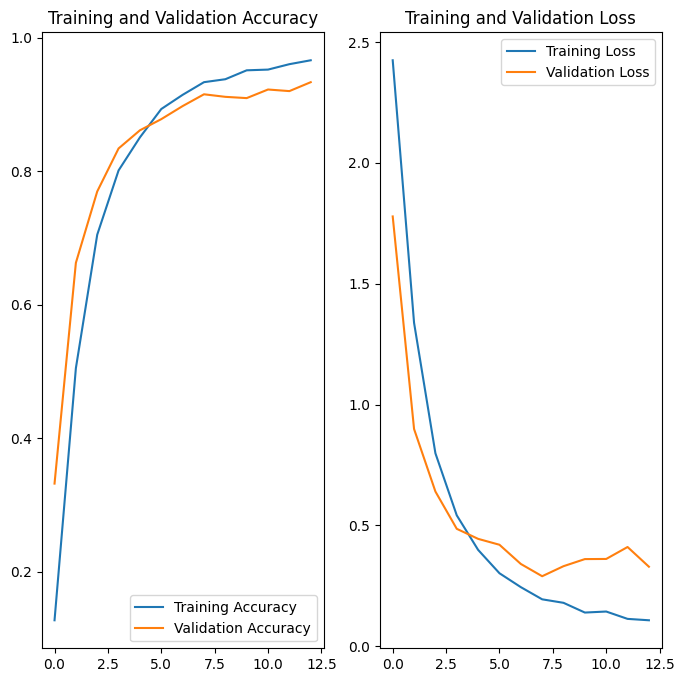

In [42]:
### visualizing the model results.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(13)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analysis of the result from Model 4
1. Accuracy on validation data is around 92% by using Augmentor library of Python.
2. Model is much less overfitted compared to previous models.
3. Validation loss is also less = 0.2894.
    